In [1]:
# The trust-region Newton method applied to LJ7 cluster in 3D 

import numpy as np
import scipy
import matplotlib.pyplot as plt
from LJhelpers import *

In [2]:
# Set up the initial configuration

# Four lical minima of LJ7:
# f1 = -16.50538417 Pentagonal bipyramid 
# f2 = -15.93504306 Capped octahedron 
# f3 = -15.59321094 Tricapped tetrahedron 
# f4 = -15.53306005 Bicapped trigonal bipyramid

# Options: model = 0,1,2,3, or 4.
# Model 0 corresponds to a random initialization.
# Models 1--4 set the system up close to the corresponding local minima
# listed above.


In [3]:
def cauchy_point(B,g,Delta):
    ng = np.linalg.norm(g)
    ps = -g*Delta/ng
    aux = np.dot(g,B @ g)
    if( aux <= 0 ):
        p = ps
    else:
        a = np.minimum(ng**3/(Delta*aux),1)
        p = ps*a
    return p

In [4]:
def descend(initial, direction):
        Na = 7 #the number of atoms
        rstar = 2**(1/6) # argument of the minimum of the Lennard-Jones pair potential V(r) = r^(-12) - r^(-6)
        tol = 1e-6 # stop iterations when ||grad f|| < tol
        iter_max = 200 # the maximal number of iterations
        draw_flag = 1 # if draw_flag = 1, draw configuration at every iteration
        # parameters for trust region
        Delta_max = 5 # the max trust-region radius
        Delta_min = 1e-12 # the minimal trust-region radius
        Delta = 1 # the initial radius
        eta = 0.1 # step rejection parameter
        subproblem_iter_max = 5 # the max # of iteration for quadratic subproblems
        tol_sub = 1e-1 # relative tolerance for the subproblem
        rho_good = 0.75 # if rho > rho_good, increase the trust-region radius
        rho_bad = 0.25 # if rho < rho_bad, decrease the trust-region radius
        # select the initial configuration
        model = initial
        if( model > 0):
            Na = 7
        xyz = initial_configuration(model,Na,rstar)
        # drawconf(xyz,0.5*rstar);
        
        x = remove_rotations_translations(xyz)
        # drawconf(LJvector2array(x),0.5*rstar)
        print("LJpot = ",LJpot(x))
        #todo move all the initialization inside
            # initialization
        f = LJpot(x)
        g = LJgrad(x)
        x_old=np.zeros(len(x))
        g_old=np.zeros(len(g))
        B=np.eye(len(x))
        norm_g = np.linalg.norm(g)
        print("Initially, f = ",f,", ||grad f|| = ",norm_g)
        
        fvals = np.zeros(iter_max)
        fvals[0] = f
        ngvals = np.zeros(iter_max)
        ngvals[0] = norm_g
        Delta = 1 # the initial trust region radius
        I = np.eye(np.size(x),dtype = float)
        
        itr = 1
    
        while (norm_g > tol and itr < iter_max):      
            # solve the constrained minimization problem 
            if direction=='Newton':
                subproblem_method='exact'
                B = LJhess(x)
                
            elif direction=='BFGS':
                subproblem_method='dogleg'
                s=x-x_old
                y=g-g_old
                B=B-(np.outer(B.dot(s),B.dot(s)))/(s.dot(B).dot(s) + 0)+(np.outer(y,y))/(y.dot(s))# +1e-12)
                
            flag_boundary = 0 
                # check if B is SPD
            eval_min = np.amin(np.real(scipy.linalg.eig(B, b=None, left=False, right=False)))
            j_sub = 0
            if( eval_min > 0 ): # B is SPD: B = R'*R, R'*R*p = -g 
                if subproblem_method=='exact':
                    p = scipy.linalg.solve(B,-g)
                    p_norm = np.linalg.norm(p)
                    if( p_norm > Delta ): # else: we are done with solbing the subproblem
                        flag_boundary = 1    
                if subproblem_method=='dogleg':
                    p_u = cauchy_point(B,g,Delta)
                    p_b = scipy.linalg.solve(B,-g)
                    if np.linalg.norm(p_b) <= Delta:
                        p=p_b
                    elif np.linalg.norm(p_u) >= Delta:
                        p=Delta*p_u/np.linalg.norm(p_u)
                    else:
                        p_diff = p_b - p_u
                        a = np.dot(p_diff, p_diff)
                        b = 2 * np.dot(p_u, p_diff)
                        c = np.dot(p_u, p_u) - Delta**2
                    
                        discr = b**2 - 4 * a * c
                        if discr < 0:
                            t = 0  
                        else:
                            t = (-b + np.sqrt(discr)) / (2 * a)
                        p = p_u + t * p_diff
                    p_norm = np.linalg.norm(p)
                    flag_boundary = 0
            else:
                flag_boundary = 1
            if( flag_boundary == 1 ): # solution lies on the boundary
                lam_min = np.maximum(-eval_min,0.0)
                lam = lam_min + 1
                R = scipy.linalg.cholesky(B+lam*I,lower = False)
                flag_subproblem_success = 0;
                while( j_sub < subproblem_iter_max ):
                    j_sub = j_sub + 1;
                    p = scipy.linalg.solve_triangular(np.transpose(R),-g,lower = True)
                    p = scipy.linalg.solve_triangular(R,p,lower = False)
                    p_norm = np.linalg.norm(p)
                    dd = np.absolute(p_norm - Delta)
                    if( dd < tol_sub*Delta ):
                        flag_subproblem_success = 1
                        break
                    q = scipy.linalg.solve_triangular(np.transpose(R),p,lower = True)
                    q_norm = np.linalg.norm(q);
                    dlam = ((p_norm/q_norm)**2)*(p_norm - Delta)/Delta
                    lam_new = lam + dlam;
                    if (lam_new > lam_min):
                        lam = lam_new
                    else:
                        lam = 0.5*(lam + lam_min)
                    R = scipy.linalg.cholesky(B+lam*I,lower = False)
                if( flag_subproblem_success == 0 ):
                    p = cauchy_point(B,g,Delta)
    
            # assess the progress
            xnew = x + p
            fnew = LJpot(xnew)
            gnew = LJgrad(xnew)
            mnew = f + np.dot(g,p) + 0.5*np.dot(p,B @ p)
            rho = (f - fnew)/(f - mnew+1e-14)
            # adjust the trust region
            if( rho < rho_bad ):
                Delta = np.maximum(0.25*Delta,Delta_min)
            else:
                #todo if(  rho > rho_good and flag_boundary == 1 ):
                Delta = np.minimum(Delta_max,2*Delta)
            # accept or reject step
            if( rho > eta ):  # accept step          
                x = xnew
                f = fnew
                g = gnew
                norm_g = np.linalg.norm(g)
                print(f'Accept: itr {itr}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}, method = {subproblem_method}')#todo {j_sub}')
            else:
                print(f'Reject: itr {itr}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}, method = {subproblem_method}')#todo  {j_sub}')
            if( itr % 20 == 19):
                # restore all coordinates
                xyz = LJvector2array(x)
                # drawconf(xyz,0.5*rstar)
            fvals[itr] = f
            ngvals[itr] = norm_g
            itr = itr + 1
        return fvals, ngvals , itr
        


LJpot =  -11.517662869490488
Initially, f =  -11.517662869490488 , ||grad f|| =  16.468632904952266
Reject: itr 1: f = -11.5176628695, |df| = 1.6469e+01, rho = -5.8089e+02, Delta = 2.5000e-01, j_sub = 2, method = exact
Accept: itr 2: f = -14.3412094921, |df| = 1.9804e+01, rho = 6.8250e-01, Delta = 5.0000e-01, j_sub = 3, method = exact
Reject: itr 3: f = -14.3412094921, |df| = 1.9804e+01, rho = -3.1388e-01, Delta = 1.2500e-01, j_sub = 1, method = exact
Accept: itr 4: f = -15.4922577755, |df| = 8.4785e+00, rho = 1.0027e+00, Delta = 2.5000e-01, j_sub = 3, method = exact
Accept: itr 5: f = -16.3799351055, |df| = 4.7291e+00, rho = 8.2344e-01, Delta = 5.0000e-01, j_sub = 3, method = exact
Accept: itr 6: f = -16.5006175532, |df| = 1.2041e+00, rho = 1.0475e+00, Delta = 1.0000e+00, j_sub = 0, method = exact
Accept: itr 7: f = -16.5053670949, |df| = 6.8239e-02, rho = 1.0335e+00, Delta = 2.0000e+00, j_sub = 0, method = exact
Accept: itr 8: f = -16.5053841676, |df| = 3.0590e-04, rho = 1.0031e+00, 

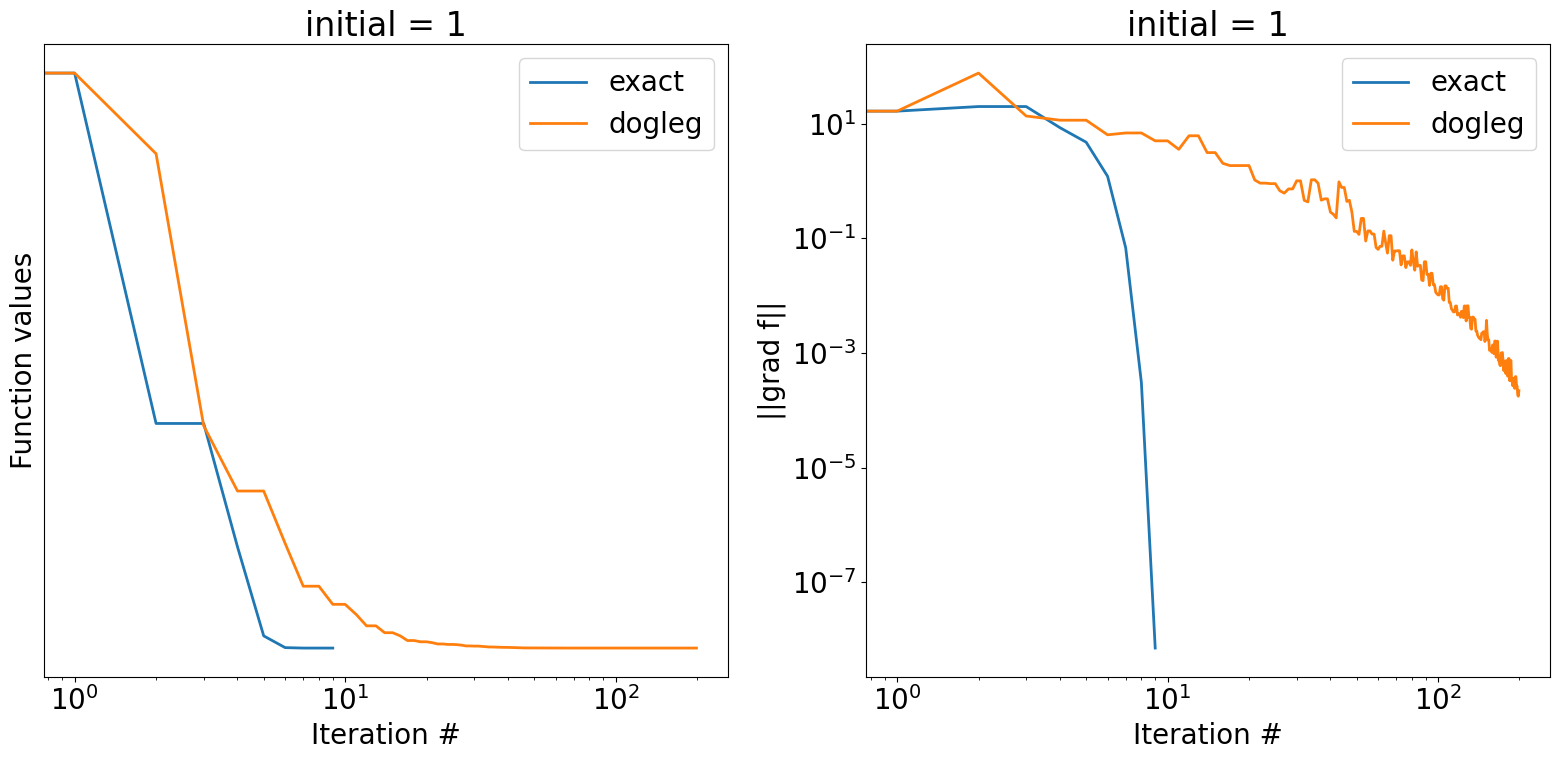

LJpot =  -15.921231995884773
Initially, f =  -15.921231995884773 , ||grad f|| =  2.119680077530262
Accept: itr 1: f = -15.9349897723, |df| = 1.3306e-01, rho = 9.5792e-01, Delta = 2.0000e+00, j_sub = 0, method = exact
Accept: itr 2: f = -15.9350430597, |df| = 4.9018e-04, rho = 1.0025e+00, Delta = 4.0000e+00, j_sub = 0, method = exact
Accept: itr 3: f = -15.9350430605, |df| = 7.8493e-09, rho = 1.0000e+00, Delta = 5.0000e+00, j_sub = 0, method = exact
LJpot =  -15.921231995884773
Initially, f =  -15.921231995884773 , ||grad f|| =  2.119680077530262
Reject: itr 1: f = -15.9212319959, |df| = 2.1197e+00, rho = -5.5948e+04, Delta = 2.5000e-01, j_sub = 0, method = dogleg
Reject: itr 2: f = -15.9212319959, |df| = 2.1197e+00, rho = -2.8130e+01, Delta = 6.2500e-02, j_sub = 0, method = dogleg
Reject: itr 3: f = -15.9212319959, |df| = 2.1197e+00, rho = -2.2595e+00, Delta = 1.5625e-02, j_sub = 0, method = dogleg
Accept: itr 4: f = -15.9316890945, |df| = 1.0923e+00, rho = 3.1710e-01, Delta = 3.1250e-

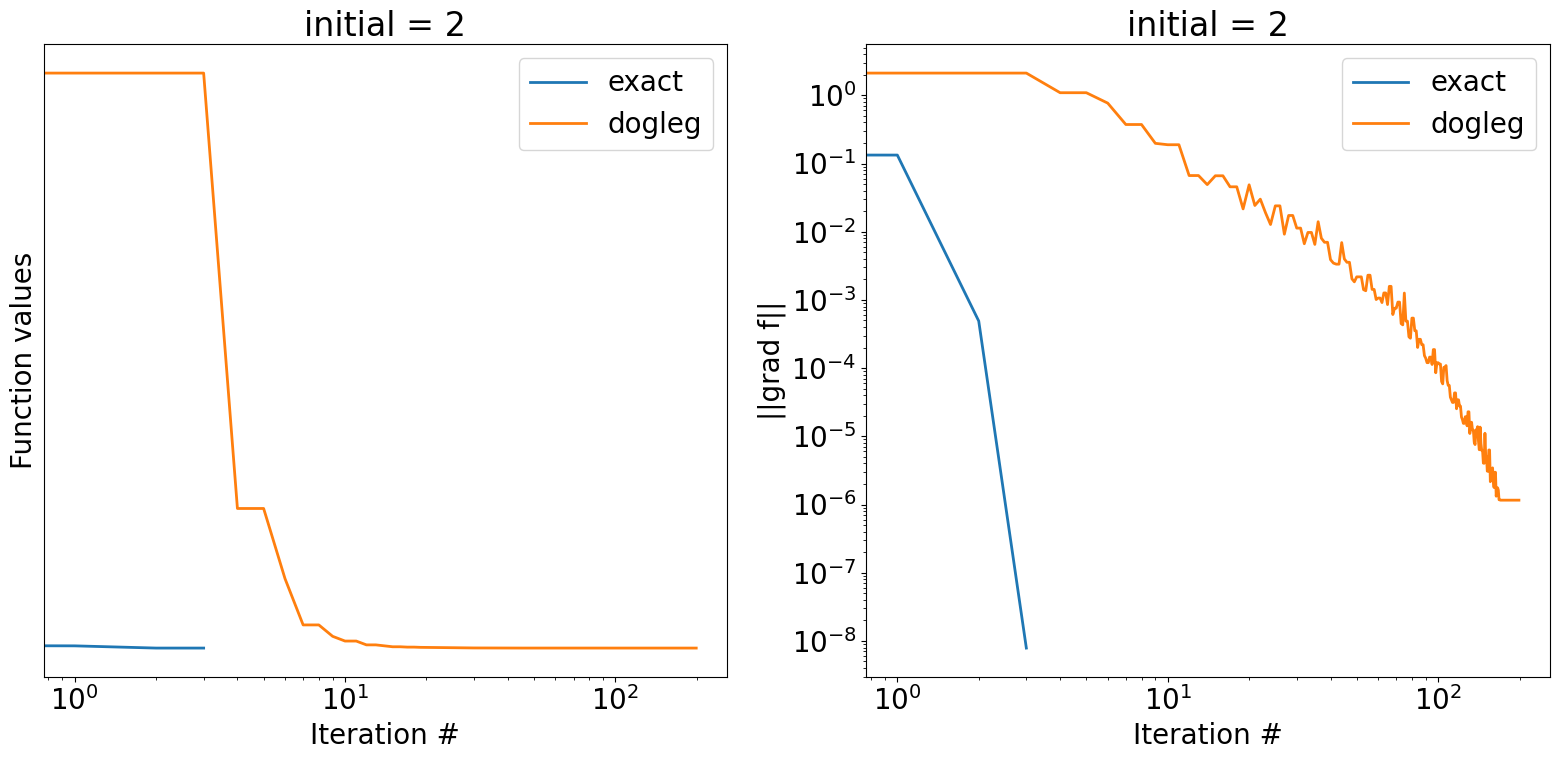

LJpot =  -15.581469160072078
Initially, f =  -15.581469160072078 , ||grad f|| =  1.46083663929382
Accept: itr 1: f = -15.5931577054, |df| = 1.1125e-01, rho = 9.5978e-01, Delta = 2.0000e+00, j_sub = 0, method = exact
Accept: itr 2: f = -15.5932109365, |df| = 5.2923e-04, rho = 1.0036e+00, Delta = 4.0000e+00, j_sub = 0, method = exact
Accept: itr 3: f = -15.5932109382, |df| = 1.7979e-08, rho = 1.0000e+00, Delta = 5.0000e+00, j_sub = 0, method = exact
LJpot =  -15.581469160072078
Initially, f =  -15.581469160072078 , ||grad f|| =  1.46083663929382
Reject: itr 1: f = -15.5814691601, |df| = 1.4608e+00, rho = -2.8546e+03, Delta = 2.5000e-01, j_sub = 0, method = dogleg
Reject: itr 2: f = -15.5814691601, |df| = 1.4608e+00, rho = -2.0750e+01, Delta = 6.2500e-02, j_sub = 0, method = dogleg
Reject: itr 3: f = -15.5814691601, |df| = 1.4608e+00, rho = -1.8699e+00, Delta = 1.5625e-02, j_sub = 0, method = dogleg
Accept: itr 4: f = -15.5901229270, |df| = 7.7071e-01, rho = 3.8130e-01, Delta = 3.1250e-02

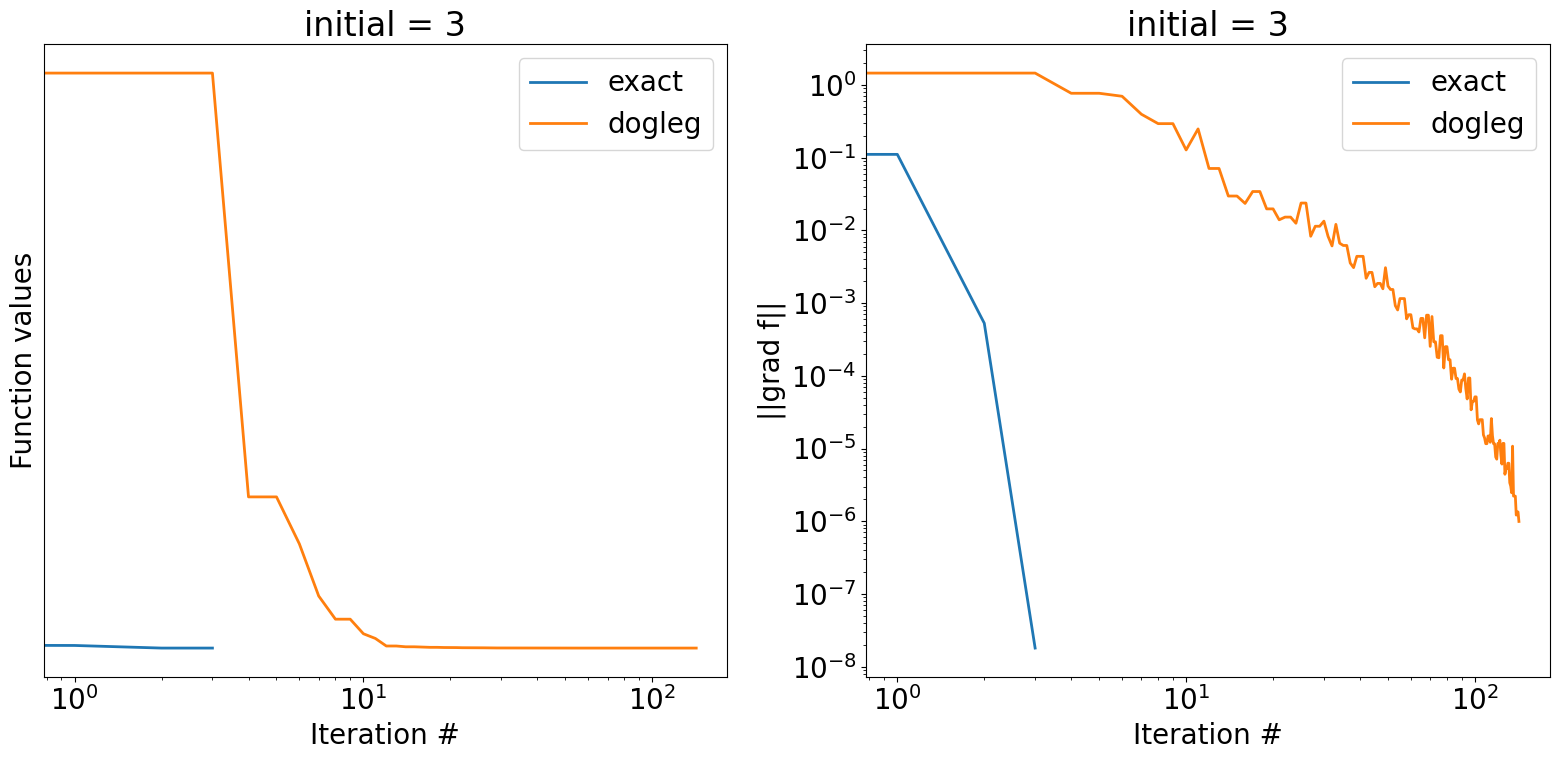

LJpot =  -15.522210169999571
Initially, f =  -15.522210169999571 , ||grad f|| =  1.2854375635525659
Accept: itr 1: f = -15.5330310403, |df| = 8.1506e-02, rho = 9.7812e-01, Delta = 2.0000e+00, j_sub = 0, method = exact
Accept: itr 2: f = -15.5330600543, |df| = 2.1920e-04, rho = 1.0018e+00, Delta = 4.0000e+00, j_sub = 0, method = exact
Accept: itr 3: f = -15.5330600546, |df| = 1.9559e-09, rho = 9.9996e-01, Delta = 5.0000e+00, j_sub = 0, method = exact
LJpot =  -15.522210169999571
Initially, f =  -15.522210169999571 , ||grad f|| =  1.2854375635525659
Reject: itr 1: f = -15.5222101700, |df| = 1.2854e+00, rho = -4.1412e+03, Delta = 2.5000e-01, j_sub = 0, method = dogleg
Reject: itr 2: f = -15.5222101700, |df| = 1.2854e+00, rho = -2.5136e+01, Delta = 6.2500e-02, j_sub = 0, method = dogleg
Reject: itr 3: f = -15.5222101700, |df| = 1.2854e+00, rho = -2.5226e+00, Delta = 1.5625e-02, j_sub = 0, method = dogleg
Accept: itr 4: f = -15.5269353636, |df| = 1.3172e+00, rho = 2.3663e-01, Delta = 3.9062

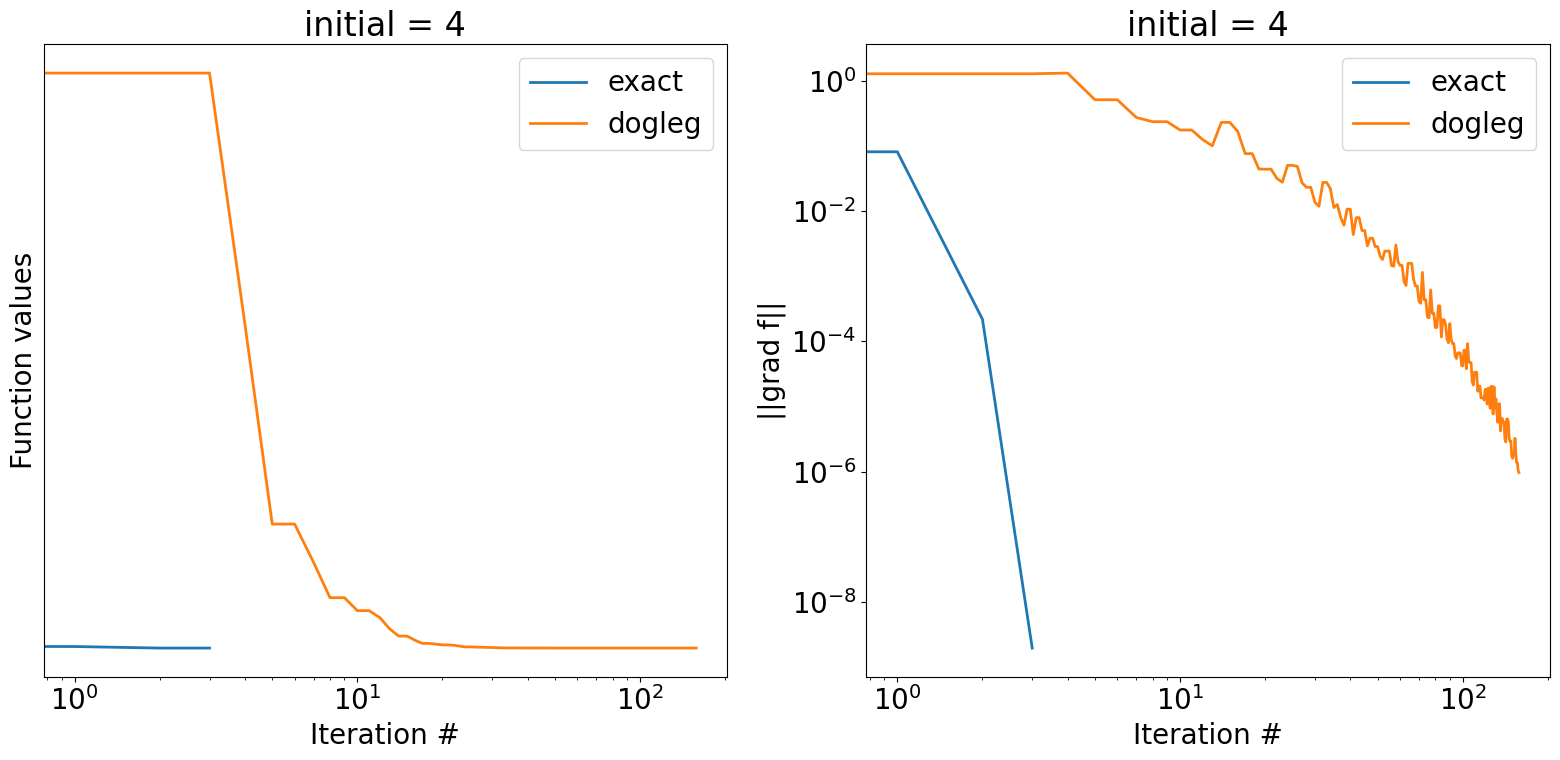

In [5]:
#4 initials near the 4 minimums 
for initial in range(1,5):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(16,8))
    direction_dict = {1:"Newton",2:"BFGS"} # 
    plot_dict = {1:"exact",2:"dogleg"} # 

    for direction in direction_dict:
        fvals, ngvals , itr=descend(initial, direction_dict[direction])
        plt.subplot(1, 2, 1)
        plt.plot(np.arange(itr),fvals[0:itr],linewidth = 2, label=plot_dict[direction]) #todo less than itermax
        plt.title("initial = "+str(initial))
        plt.xlabel("Iteration #")
        plt.xscale("log")
        plt.ylabel("Function values")
        #plt.yscale("log")
        plt.yscale('symlog', linthresh=10)
        plt.legend()
        #second plot of gradients
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(itr),ngvals[0:itr],linewidth = 2, label=plot_dict[direction])
        plt.title("initial = "+str(initial))
        plt.xlabel("Iteration #")
        plt.xscale("log")
        plt.ylabel("||grad f||")
        plt.yscale("log")
        plt.legend()
    plt.tight_layout()    
    plt.show()



LJpot =  26384237801.750793
Initially, f =  26384237801.750793 , ||grad f|| =  2083527871476.9412
Accept: itr 1: f = 10842357437.0927200317, |df| = 7.9506e+11, rho = 1.2757e+00, Delta = 2.0000e+00, j_sub = 2, method = exact
Accept: itr 2: f = 4455579559.6217575073, |df| = 3.0339e+11, rho = 1.2761e+00, Delta = 4.0000e+00, j_sub = 2, method = exact
Accept: itr 3: f = 1830978467.6093344688, |df| = 1.1577e+11, rho = 1.2761e+00, Delta = 5.0000e+00, j_sub = 2, method = exact
Accept: itr 4: f = 754296907.2446854115, |df| = 4.4177e+10, rho = 1.2741e+00, Delta = 5.0000e+00, j_sub = 3, method = exact
Reject: itr 5: f = 754296907.2446854115, |df| = 4.4177e+10, rho = 8.3660e-02, Delta = 1.2500e+00, j_sub = 3, method = exact
Accept: itr 6: f = 309232194.5299462080, |df| = 1.6860e+10, rho = 6.6503e-01, Delta = 2.5000e+00, j_sub = 2, method = exact
Accept: itr 7: f = 127072216.4905354679, |df| = 6.4334e+09, rho = 1.2763e+00, Delta = 5.0000e+00, j_sub = 2, method = exact
Accept: itr 8: f = 52216346.04

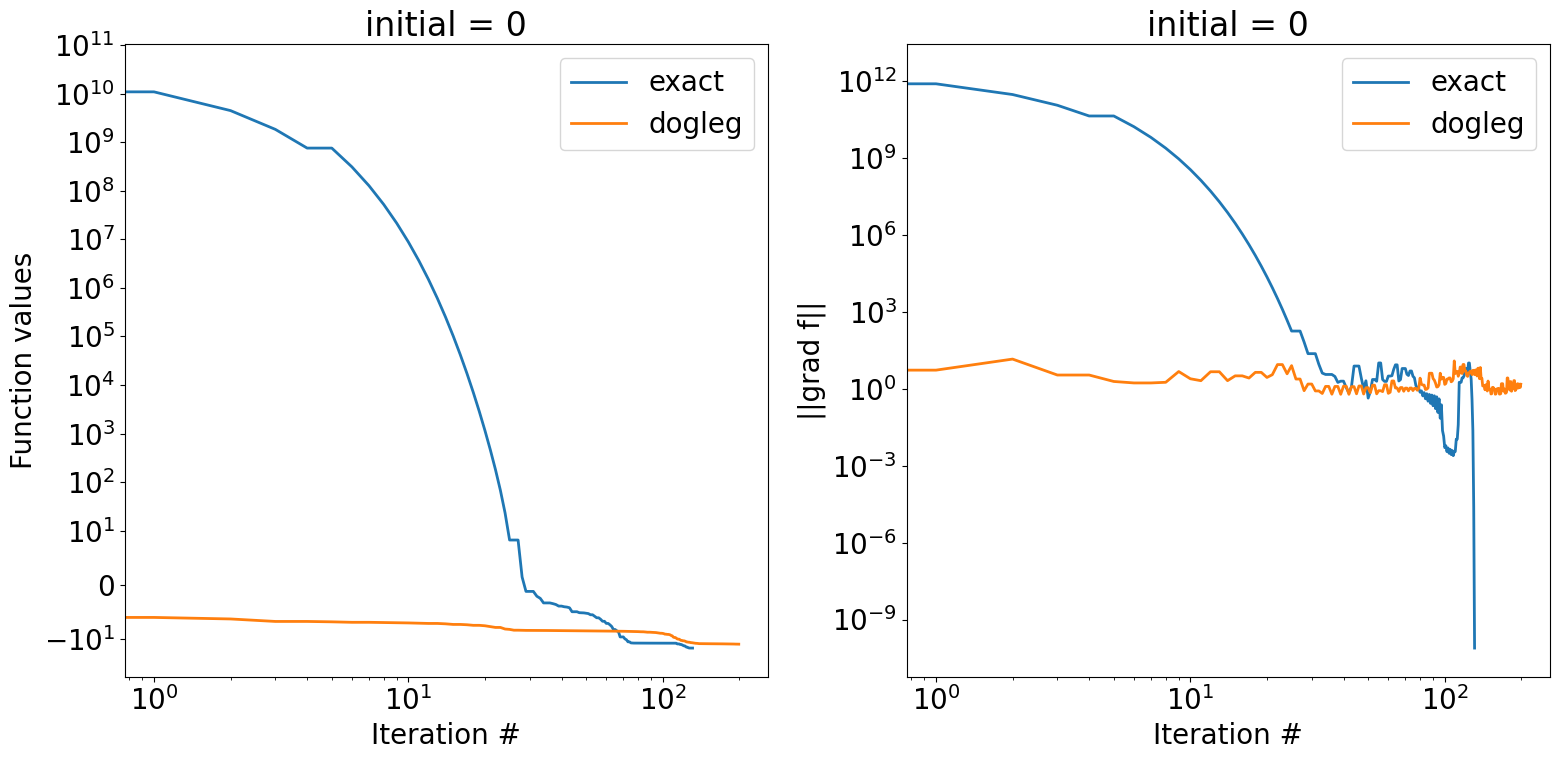

LJpot =  761.3102441791841
Initially, f =  761.3102441791841 , ||grad f|| =  13896.010729595377
Accept: itr 1: f = 280.4230571125, |df| = 5.1784e+03, rho = 5.2073e-01, Delta = 2.0000e+00, j_sub = 2, method = exact
Accept: itr 2: f = 106.9201799815, |df| = 1.9612e+03, rho = 5.5400e-01, Delta = 4.0000e+00, j_sub = 4, method = exact
Reject: itr 3: f = 106.9201799815, |df| = 1.9612e+03, rho = -2.0859e+03, Delta = 1.0000e+00, j_sub = 2, method = exact
Reject: itr 4: f = 106.9201799815, |df| = 1.9612e+03, rho = -1.8824e+00, Delta = 2.5000e-01, j_sub = 2, method = exact
Accept: itr 5: f = 36.8676012557, |df| = 7.3965e+02, rho = 1.2554e+00, Delta = 5.0000e-01, j_sub = 3, method = exact
Accept: itr 6: f = 27.3016154425, |df| = 4.4126e+02, rho = 3.7913e-01, Delta = 1.0000e+00, j_sub = 2, method = exact
Reject: itr 7: f = 27.3016154425, |df| = 4.4126e+02, rho = -1.7234e+00, Delta = 2.5000e-01, j_sub = 2, method = exact
Accept: itr 8: f = 3.7705084110, |df| = 1.4843e+02, rho = 7.9874e-01, Delta = 

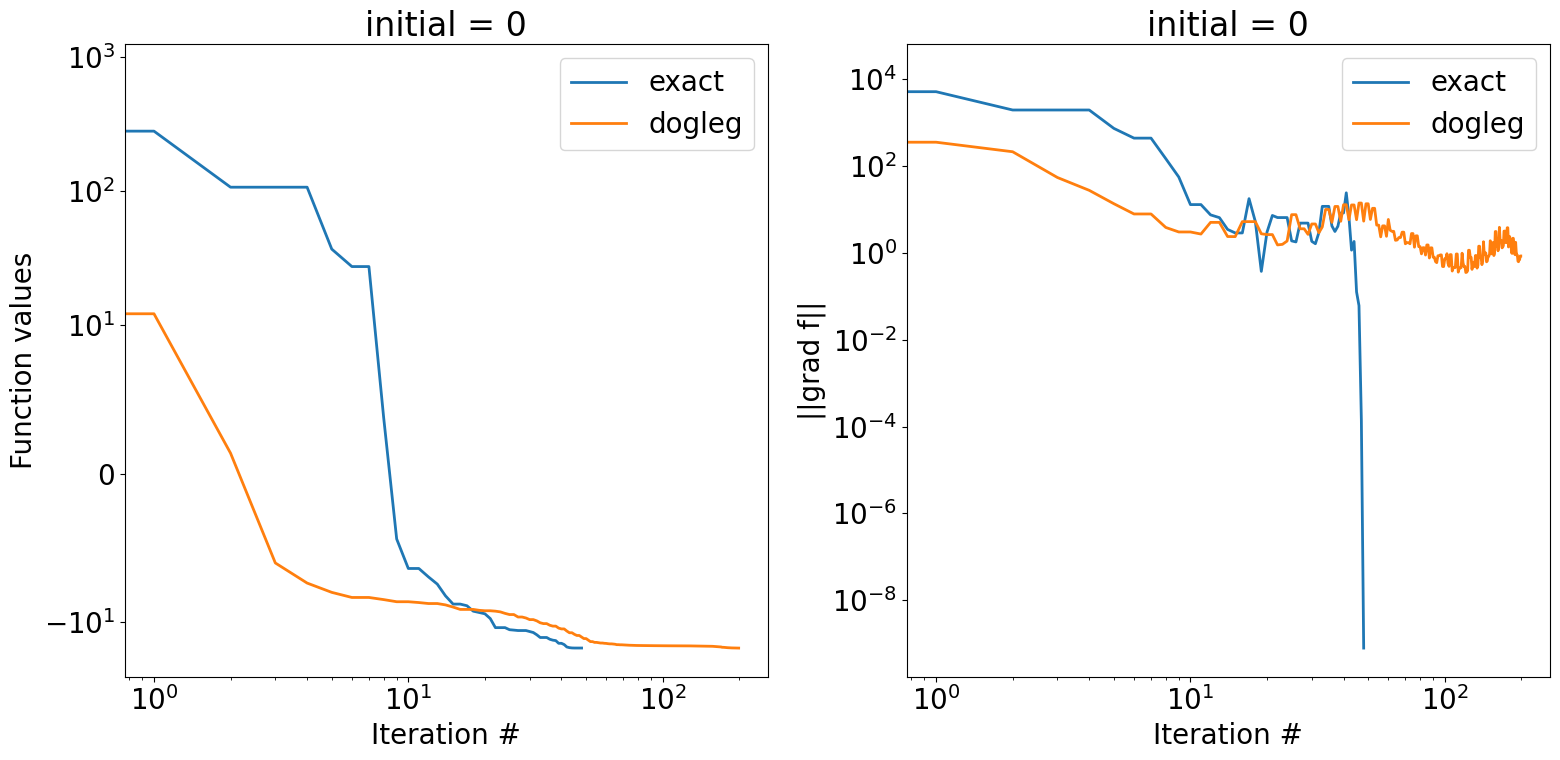

LJpot =  733.085342398548
Initially, f =  733.085342398548 , ||grad f|| =  14463.316291393112
Reject: itr 1: f = 733.0853423985, |df| = 1.4463e+04, rho = -8.8927e+03, Delta = 2.5000e-01, j_sub = 2, method = exact
Accept: itr 2: f = 252.3420122061, |df| = 2.9630e+03, rho = 2.9425e-01, Delta = 5.0000e-01, j_sub = 2, method = exact
Accept: itr 3: f = 61.5363872061, |df| = 1.1712e+03, rho = 5.5921e-01, Delta = 1.0000e+00, j_sub = 2, method = exact
Accept: itr 4: f = 17.0471586639, |df| = 4.2940e+02, rho = 8.4249e-01, Delta = 2.0000e+00, j_sub = 2, method = exact
Reject: itr 5: f = 17.0471586639, |df| = 4.2940e+02, rho = -3.0357e+02, Delta = 5.0000e-01, j_sub = 4, method = exact
Accept: itr 6: f = 0.4195548039, |df| = 1.5904e+02, rho = 1.1754e+00, Delta = 1.0000e+00, j_sub = 3, method = exact
Accept: itr 7: f = -7.4451911977, |df| = 6.4772e+01, rho = 6.7807e-01, Delta = 2.0000e+00, j_sub = 2, method = exact
Reject: itr 8: f = -7.4451911977, |df| = 6.4772e+01, rho = -1.1777e+03, Delta = 5.00

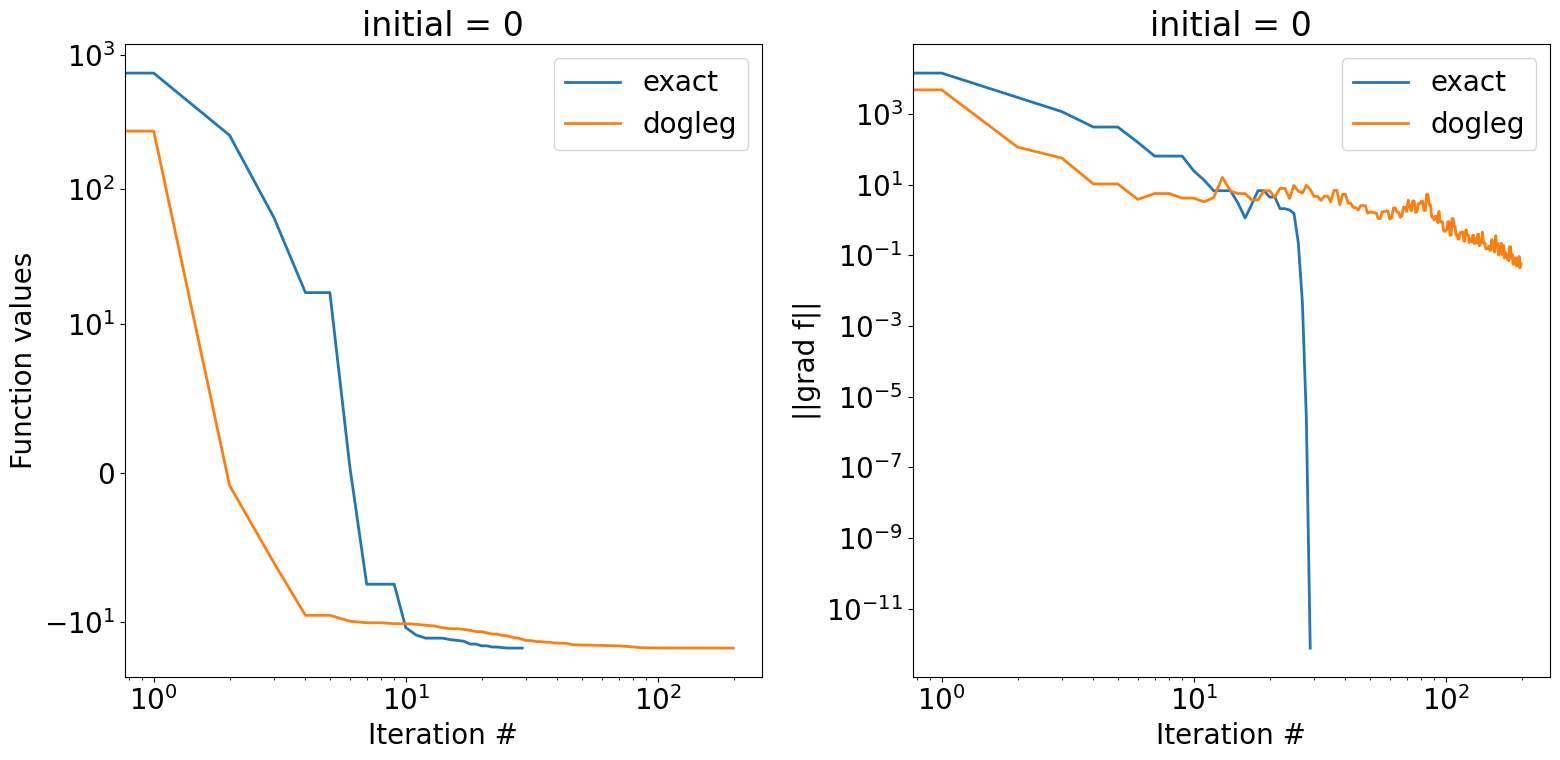

LJpot =  -7.179926601145804
Initially, f =  -7.179926601145804 , ||grad f|| =  8.526611121882688
Reject: itr 1: f = -7.1799266011, |df| = 8.5266e+00, rho = -1.7953e+01, Delta = 2.5000e-01, j_sub = 3, method = exact
Accept: itr 2: f = -8.6351928411, |df| = 6.5732e+00, rho = 7.0861e-01, Delta = 5.0000e-01, j_sub = 3, method = exact
Reject: itr 3: f = -8.6351928411, |df| = 6.5732e+00, rho = -5.9864e+00, Delta = 1.2500e-01, j_sub = 2, method = exact
Accept: itr 4: f = -9.1553958641, |df| = 3.5509e+00, rho = 9.6203e-01, Delta = 2.5000e-01, j_sub = 3, method = exact
Accept: itr 5: f = -9.8596358601, |df| = 2.7894e+00, rho = 8.8586e-01, Delta = 5.0000e-01, j_sub = 2, method = exact
Accept: itr 6: f = -10.2026380773, |df| = 6.5800e+00, rho = 4.6008e-01, Delta = 1.0000e+00, j_sub = 5, method = exact
Reject: itr 7: f = -10.2026380773, |df| = 6.5800e+00, rho = -1.3240e+04, Delta = 2.5000e-01, j_sub = 2, method = exact
Reject: itr 8: f = -10.2026380773, |df| = 6.5800e+00, rho = -3.1963e+00, Delta 

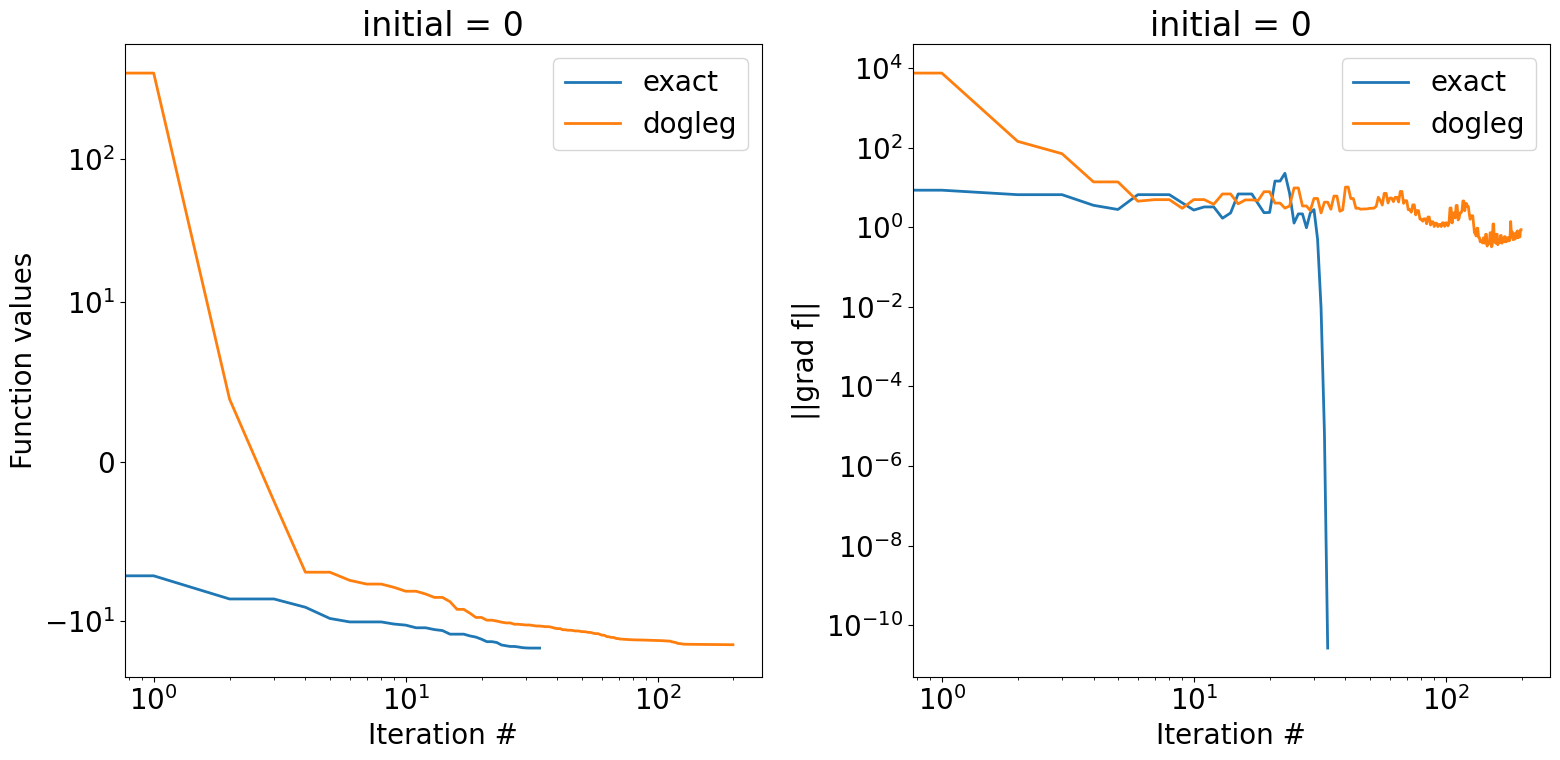

LJpot =  -6.171127289282248
Initially, f =  -6.171127289282248 , ||grad f|| =  6.726109262720338
Reject: itr 1: f = -6.1711272893, |df| = 6.7261e+00, rho = -4.7900e+00, Delta = 2.5000e-01, j_sub = 3, method = exact
Accept: itr 2: f = -7.7261685378, |df| = 5.1429e+00, rho = 8.9920e-01, Delta = 5.0000e-01, j_sub = 3, method = exact
Reject: itr 3: f = -7.7261685378, |df| = 5.1429e+00, rho = -2.6741e-01, Delta = 1.2500e-01, j_sub = 3, method = exact
Accept: itr 4: f = -8.3575863718, |df| = 5.0013e+00, rho = 9.8954e-01, Delta = 2.5000e-01, j_sub = 3, method = exact
Accept: itr 5: f = -9.5882280134, |df| = 3.2067e+00, rho = 8.6337e-01, Delta = 5.0000e-01, j_sub = 3, method = exact
Reject: itr 6: f = -9.5882280134, |df| = 3.2067e+00, rho = -2.7827e+00, Delta = 1.2500e-01, j_sub = 2, method = exact
Accept: itr 7: f = -9.9200859209, |df| = 2.4517e+00, rho = 9.7544e-01, Delta = 2.5000e-01, j_sub = 3, method = exact
Accept: itr 8: f = -10.1329208892, |df| = 7.8560e+00, rho = 3.3356e-01, Delta = 5

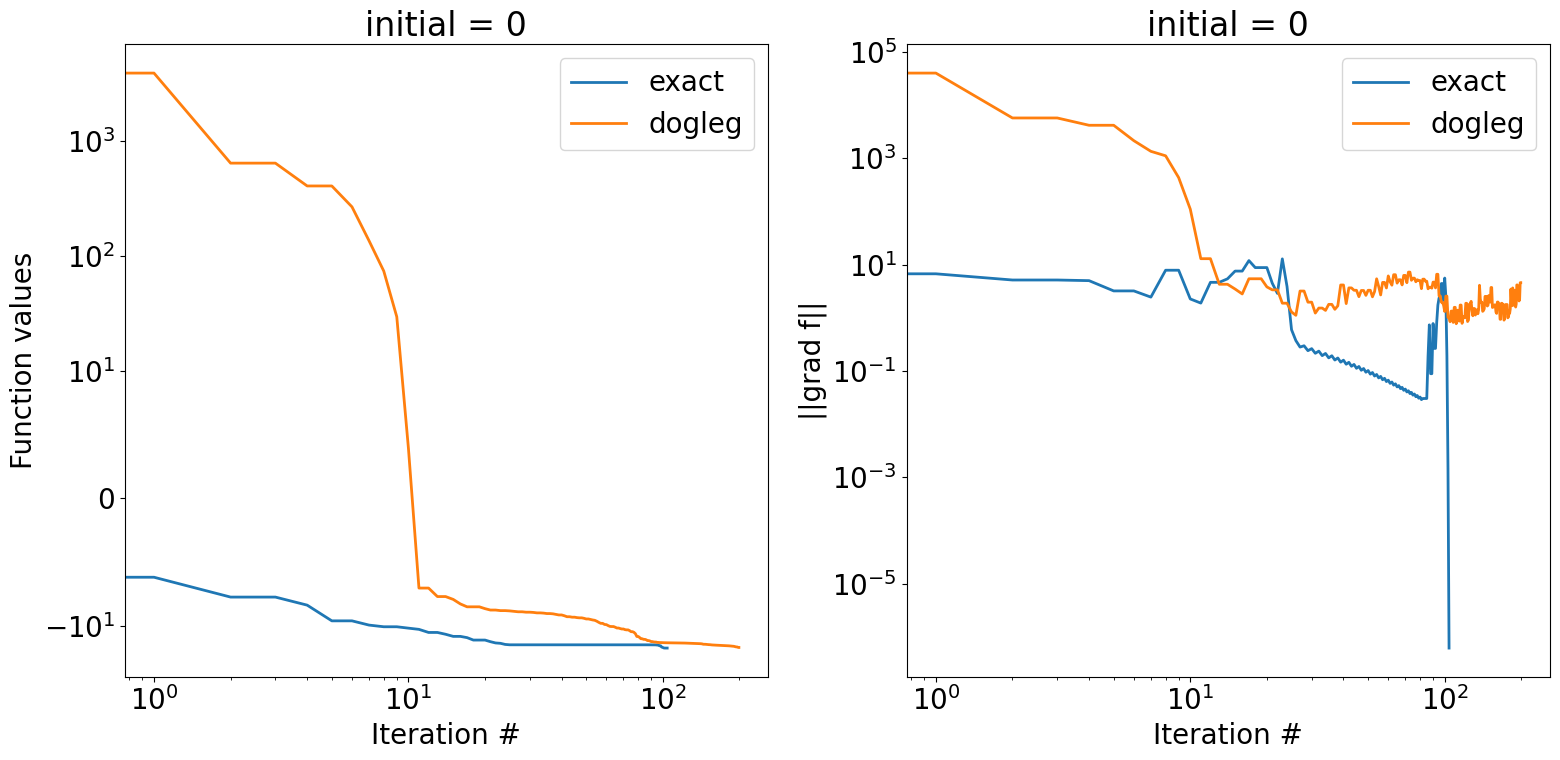

LJpot =  -7.210852936047722
Initially, f =  -7.210852936047722 , ||grad f|| =  7.829965019525804
Reject: itr 1: f = -7.2108529360, |df| = 7.8300e+00, rho = -6.9517e+02, Delta = 2.5000e-01, j_sub = 3, method = exact
Accept: itr 2: f = -8.2290191953, |df| = 8.9838e+00, rho = 5.5607e-01, Delta = 5.0000e-01, j_sub = 3, method = exact
Accept: itr 3: f = -10.1964024106, |df| = 8.0681e+00, rho = 8.5392e-01, Delta = 1.0000e+00, j_sub = 2, method = exact
Reject: itr 4: f = -10.1964024106, |df| = 8.0681e+00, rho = -6.5353e+02, Delta = 2.5000e-01, j_sub = 2, method = exact
Accept: itr 5: f = -11.4884318909, |df| = 4.9442e+00, rho = 7.9320e-01, Delta = 5.0000e-01, j_sub = 3, method = exact
Accept: itr 6: f = -12.0395799154, |df| = 8.3688e+00, rho = 7.5802e-01, Delta = 1.0000e+00, j_sub = 3, method = exact
Reject: itr 7: f = -12.0395799154, |df| = 8.3688e+00, rho = -5.3118e+05, Delta = 2.5000e-01, j_sub = 1, method = exact
Reject: itr 8: f = -12.0395799154, |df| = 8.3688e+00, rho = -2.5871e+00, Del

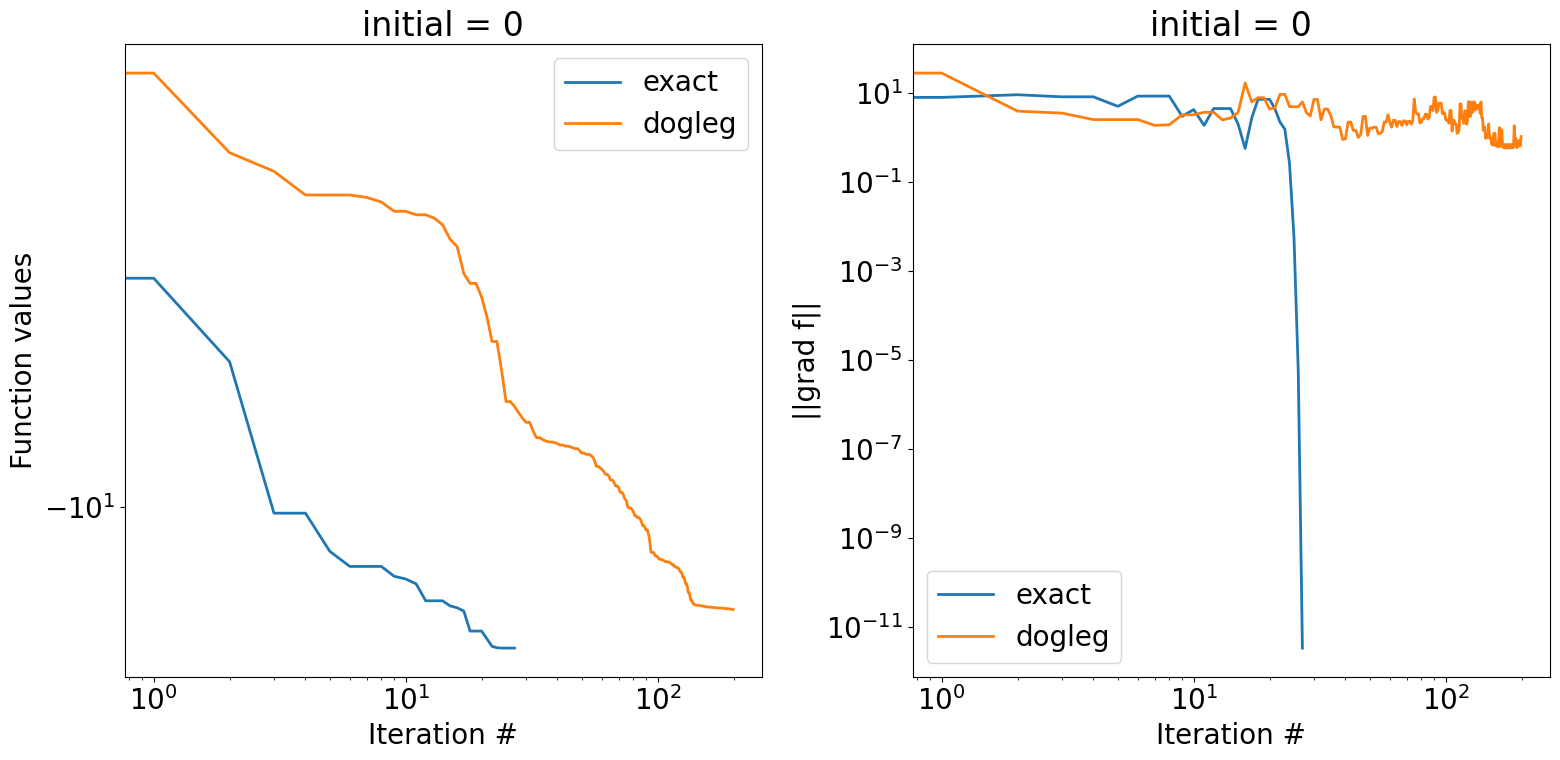

LJpot =  263.343590809229
Initially, f =  263.343590809229 , ||grad f|| =  4705.243595711114
Accept: itr 1: f = 170.8652769546, |df| = 2.2703e+03, rho = 4.5814e-01, Delta = 2.0000e+00, j_sub = 2, method = exact
Reject: itr 2: f = 170.8652769546, |df| = 2.2703e+03, rho = -1.3751e+00, Delta = 5.0000e-01, j_sub = 1, method = exact
Accept: itr 3: f = 59.6301748679, |df| = 8.5582e+02, rho = 1.1806e+00, Delta = 1.0000e+00, j_sub = 2, method = exact
Accept: itr 4: f = 17.9348653791, |df| = 3.2796e+02, rho = 4.7880e-01, Delta = 2.0000e+00, j_sub = 1, method = exact
Reject: itr 5: f = 17.9348653791, |df| = 3.2796e+02, rho = -8.7619e+03, Delta = 5.0000e-01, j_sub = 3, method = exact
Accept: itr 6: f = -0.4189644881, |df| = 1.3508e+02, rho = 7.3246e-01, Delta = 1.0000e+00, j_sub = 2, method = exact
Reject: itr 7: f = -0.4189644881, |df| = 1.3508e+02, rho = -1.2442e+08, Delta = 2.5000e-01, j_sub = 2, method = exact
Accept: itr 8: f = -6.8901936678, |df| = 5.0010e+01, rho = 1.0907e+00, Delta = 5.00

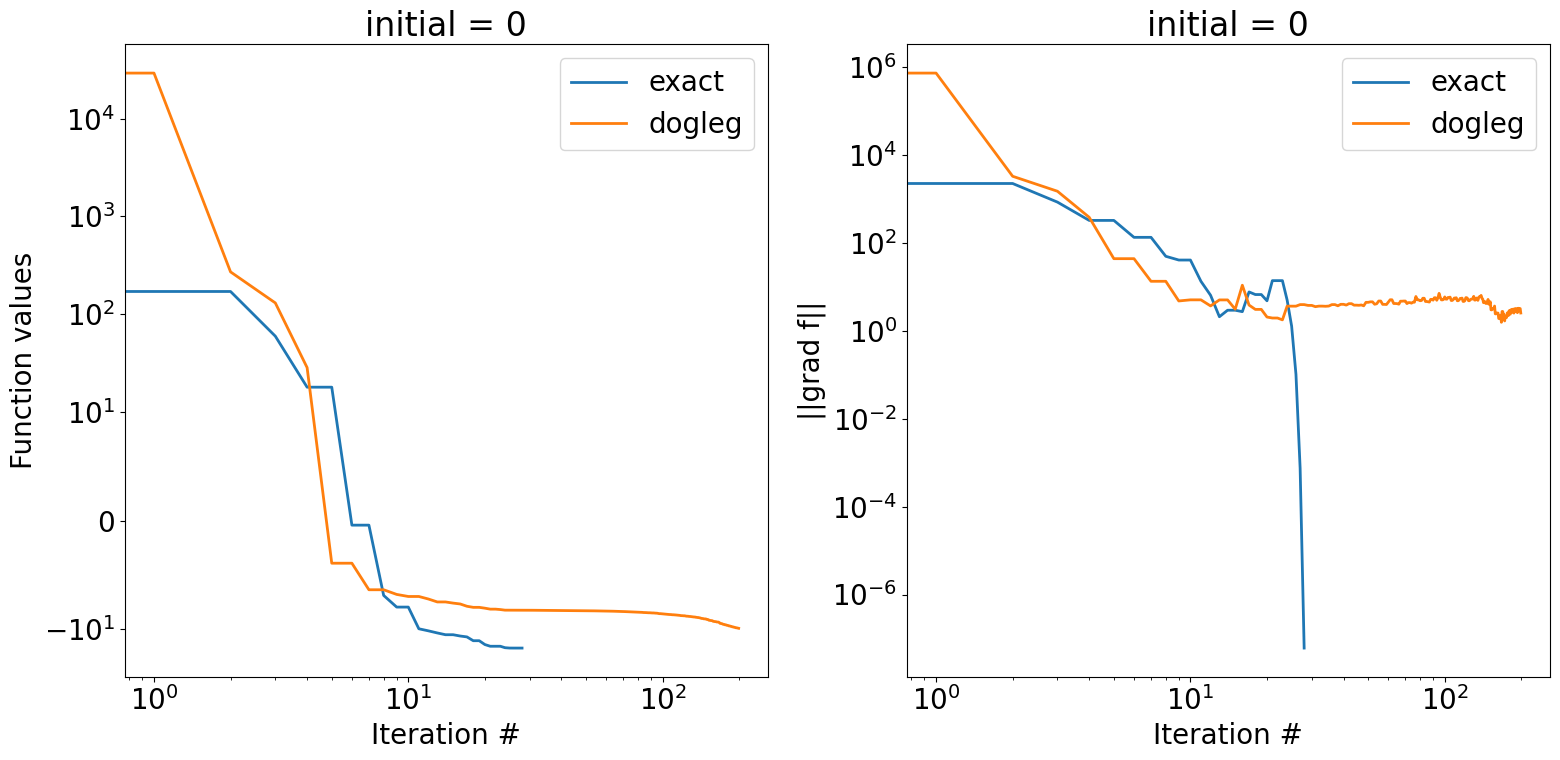

LJpot =  9.333843501210001
Initially, f =  9.333843501210001 , ||grad f|| =  286.0408640506294
Reject: itr 1: f = 9.3338435012, |df| = 2.8604e+02, rho = -3.2346e+01, Delta = 2.5000e-01, j_sub = 2, method = exact
Accept: itr 2: f = -3.1142689925, |df| = 6.4967e+01, rho = 5.0005e-01, Delta = 5.0000e-01, j_sub = 2, method = exact
Accept: itr 3: f = -6.9955415896, |df| = 4.7540e+00, rho = 2.8381e-01, Delta = 1.0000e+00, j_sub = 2, method = exact
Reject: itr 4: f = -6.9955415896, |df| = 4.7540e+00, rho = -9.0716e+01, Delta = 2.5000e-01, j_sub = 3, method = exact
Reject: itr 5: f = -6.9955415896, |df| = 4.7540e+00, rho = -2.2524e+00, Delta = 6.2500e-02, j_sub = 3, method = exact
Accept: itr 6: f = -7.2555383088, |df| = 3.0939e+00, rho = 9.3374e-01, Delta = 1.2500e-01, j_sub = 3, method = exact
Accept: itr 7: f = -7.5107645727, |df| = 2.0307e+00, rho = 9.5962e-01, Delta = 2.5000e-01, j_sub = 3, method = exact
Accept: itr 8: f = -8.1435821614, |df| = 3.0736e+00, rho = 9.9285e-01, Delta = 5.000

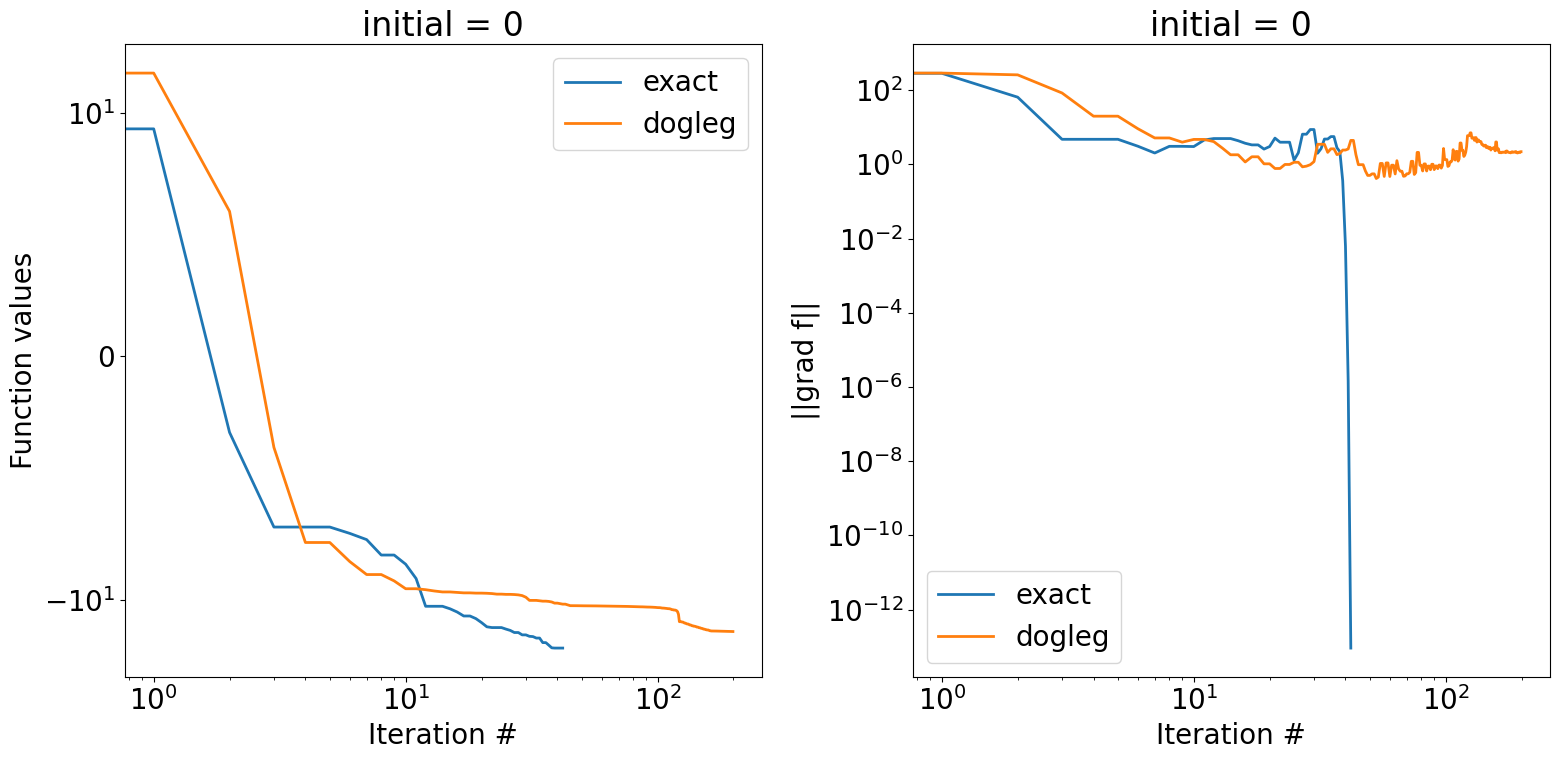

LJpot =  -6.422706585330321
Initially, f =  -6.422706585330321 , ||grad f|| =  7.5133697496803675
Reject: itr 1: f = -6.4227065853, |df| = 7.5134e+00, rho = -1.0862e+04, Delta = 2.5000e-01, j_sub = 2, method = exact
Accept: itr 2: f = -7.7842324104, |df| = 7.5411e+00, rho = 7.6622e-01, Delta = 5.0000e-01, j_sub = 3, method = exact
Reject: itr 3: f = -7.7842324104, |df| = 7.5411e+00, rho = -2.1818e+00, Delta = 1.2500e-01, j_sub = 2, method = exact
Accept: itr 4: f = -8.2334357010, |df| = 2.2729e+00, rho = 8.0602e-01, Delta = 2.5000e-01, j_sub = 3, method = exact
Accept: itr 5: f = -8.5400944866, |df| = 2.0681e+00, rho = 1.0409e+00, Delta = 5.0000e-01, j_sub = 2, method = exact
Reject: itr 6: f = -8.5400944866, |df| = 2.0681e+00, rho = -6.9122e-02, Delta = 1.2500e-01, j_sub = 2, method = exact
Accept: itr 7: f = -8.7706438105, |df| = 2.1497e+00, rho = 1.0297e+00, Delta = 2.5000e-01, j_sub = 3, method = exact
Accept: itr 8: f = -9.3759531059, |df| = 2.7698e+00, rho = 8.3757e-01, Delta = 5

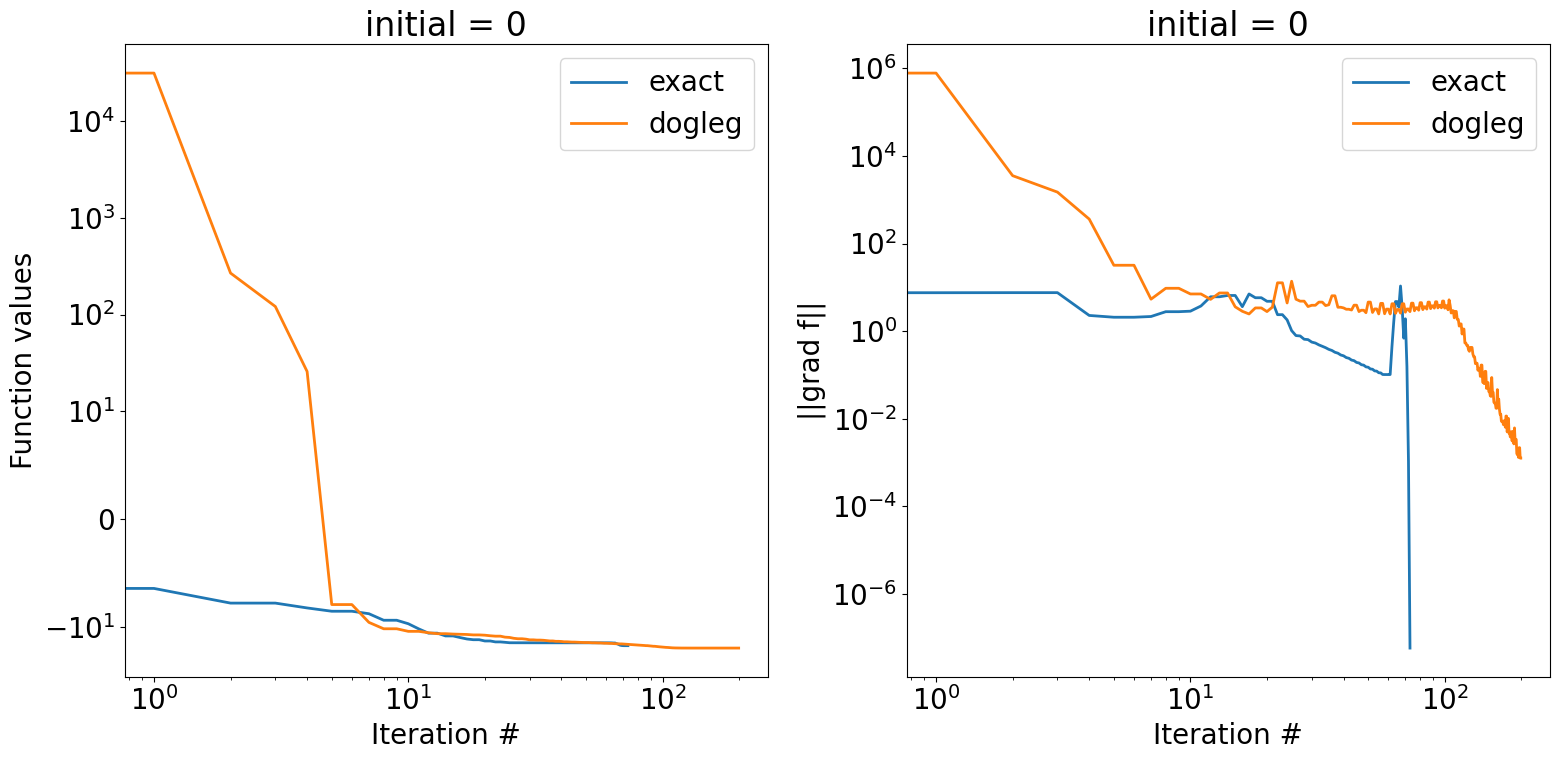

LJpot =  -5.753761581860478
Initially, f =  -5.753761581860478 , ||grad f|| =  6.927603076737165
Reject: itr 1: f = -5.7537615819, |df| = 6.9276e+00, rho = -1.6843e+03, Delta = 2.5000e-01, j_sub = 2, method = exact
Accept: itr 2: f = -6.9900605977, |df| = 3.9370e+00, rho = 7.3383e-01, Delta = 5.0000e-01, j_sub = 3, method = exact
Accept: itr 3: f = -8.1194218053, |df| = 7.1080e+00, rho = 6.5625e-01, Delta = 1.0000e+00, j_sub = 2, method = exact
Reject: itr 4: f = -8.1194218053, |df| = 7.1080e+00, rho = -2.1186e-01, Delta = 2.5000e-01, j_sub = 1, method = exact
Accept: itr 5: f = -8.7404705803, |df| = 4.1547e+00, rho = 6.4440e-01, Delta = 5.0000e-01, j_sub = 3, method = exact
Accept: itr 6: f = -9.3324428824, |df| = 3.7493e+00, rho = 5.7171e-01, Delta = 1.0000e+00, j_sub = 1, method = exact
Reject: itr 7: f = -9.3324428824, |df| = 3.7493e+00, rho = -2.6289e+00, Delta = 2.5000e-01, j_sub = 2, method = exact
Accept: itr 8: f = -9.5567212849, |df| = 7.3868e+00, rho = 5.9108e-01, Delta = 5.

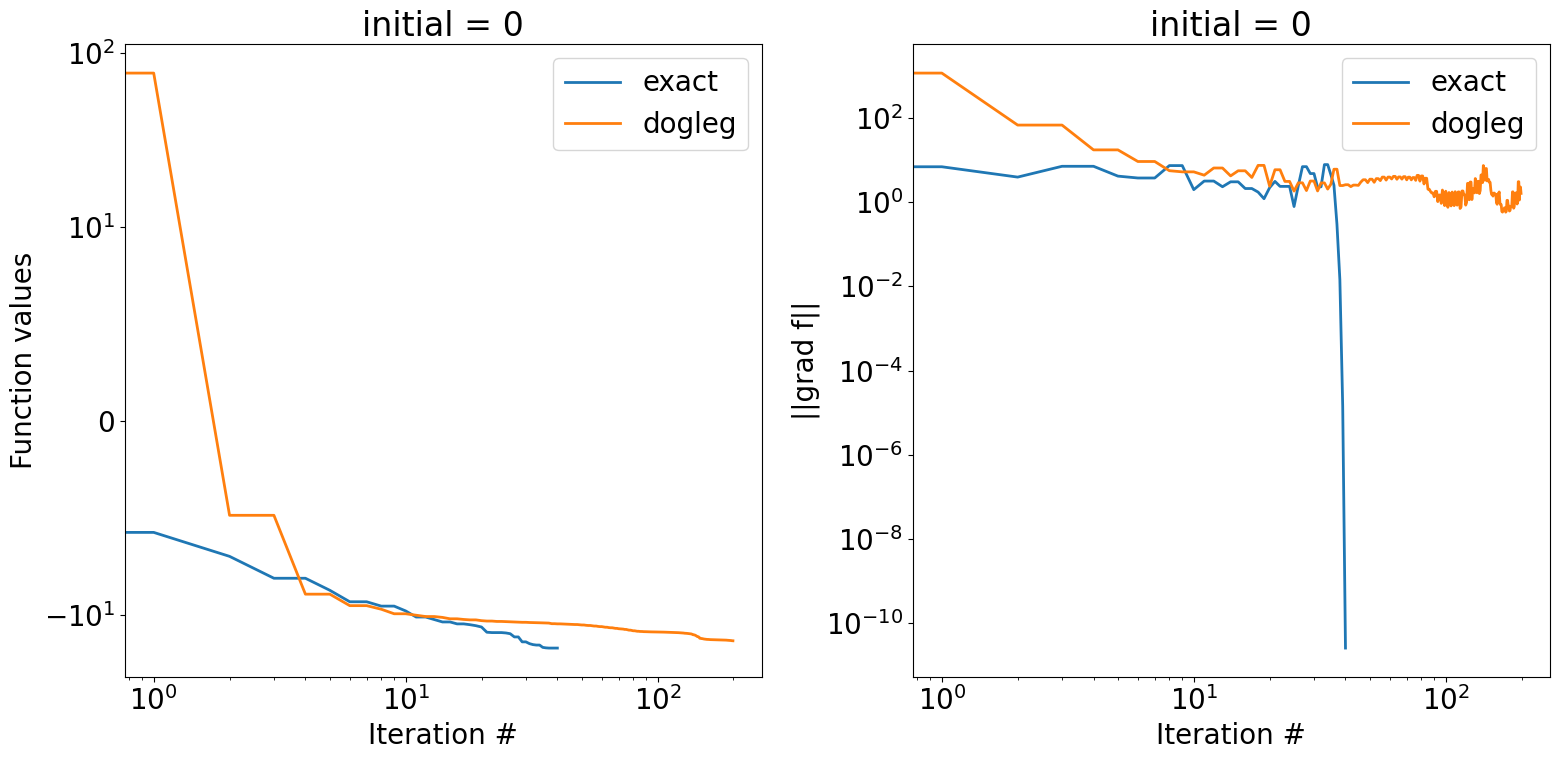

In [6]:
#random initials
initial=0
for i in range(10):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(16,8))
    direction_dict = {1:"Newton",2:"BFGS"} #0:"Steepest Descent",
    plot_dict = {1:"exact",2:"dogleg"} # 

    for direction in direction_dict:
        fvals, ngvals , itr=descend(initial,direction_dict[direction])
        plt.subplot(1, 2, 1)
        plt.plot(np.arange(itr),fvals[0:itr],linewidth = 2, label=plot_dict[direction]) #todo less than itermax
        plt.title("initial = "+str(initial))
        plt.xlabel("Iteration #")
        plt.xscale("log")
        plt.ylabel("Function values")
        plt.yscale('symlog', linthresh=10)
        plt.legend()
        #second plot of gradients
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(itr),ngvals[0:itr],linewidth = 2, label=plot_dict[direction])
        plt.title("initial = "+str(initial))
        plt.xlabel("Iteration #")
        plt.xscale("log")
        plt.ylabel("||grad f||")
        plt.yscale("log")
        plt.legend()
    plt.tight_layout()    
    plt.show()
    
    #todo: change all to l